In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')


In [8]:
folder = os.listdir('/kaggle/input/brain-tumor-segmentation')
folder.sort()
folder



['images', 'masks']

In [9]:
image_files = sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/images'))
mask_files = sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/masks'))

print(image_files[:7])
print("------------------------------------------------------------------------------")
print(mask_files[:7])

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png']
------------------------------------------------------------------------------
['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png']


In [11]:
def display_images_masks(imagepath, maskpath):

        count = 0

        for image_file, mask_file in zip(image_files, mask_files):

            if count >= 4: 
                break


            imagepath_full = os.path.join(imagepath, image_file)
            maskpath_full = os.path.join(maskpath, mask_file)

            image = cv2.imread(imagepath_full)
            mask = cv2.imread(maskpath_full)

            if image is None:
                raise ValueError(f"Image at path {imagepath_full} could not be loaded")
            if mask is None:
                raise ValueError(f"Mask at path {maskpath_full} could not be loaded")

            plt.figure(figsize=(10, 10))

        
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title('Image')

      
            plt.subplot(1, 3, 2)
            plt.imshow(mask)
            plt.title('Mask')

        
            plt.subplot(1, 3, 3)

            sample = np.array(np.squeeze(mask), dtype = np.uint8)
            contours, hier = cv2.findContours(sample[:,:,1],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            sample_over_gt = cv2.drawContours(image, contours, -1,[0,255,0], thickness=-1)
            plt.imshow(sample_over_gt)
            plt.title('Image with Contours')


            plt.show()
            count += 1

In [12]:
IMAGES_PATH='/kaggle/input/brain-tumor-segmentation/images'
MASKS_PATH='/kaggle/input/brain-tumor-segmentation/masks'

SIZE=256
CHANNEL=1

Num_Of_Classes=1

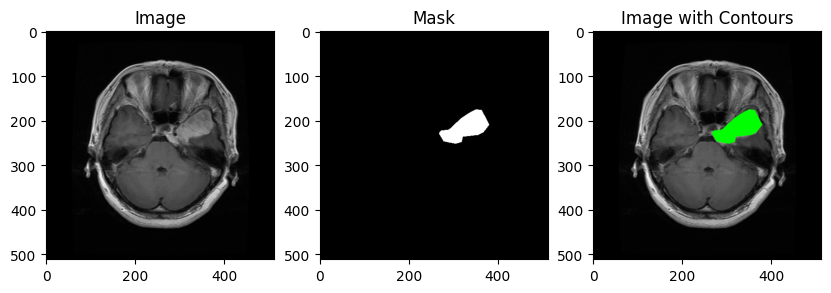

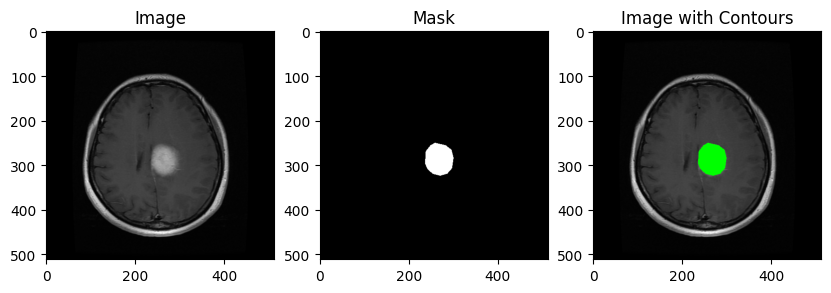

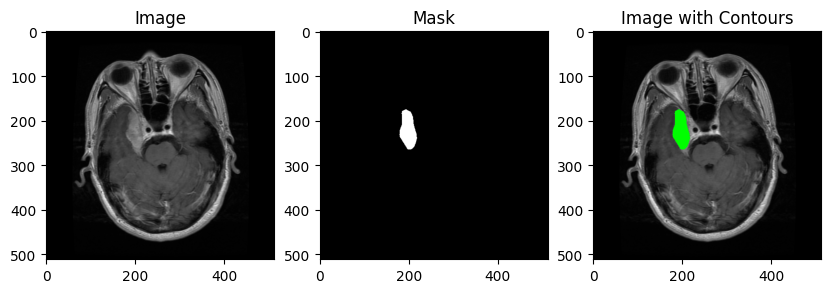

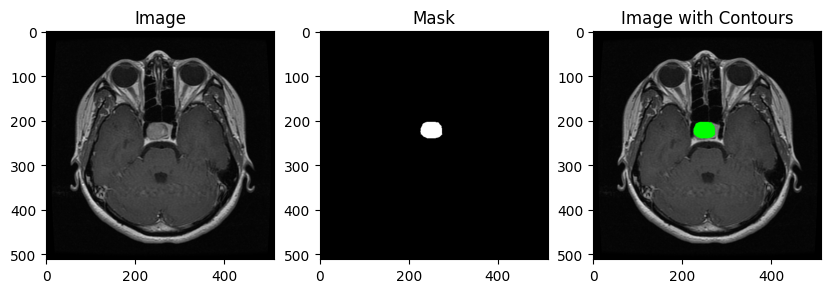

In [13]:
display_images_masks(IMAGES_PATH,MASKS_PATH)

In [14]:
images_size=[]
masks_size=[]

for image_file, mask_file in tqdm(zip(image_files, mask_files)):


    imagepath_full = os.path.join(IMAGES_PATH, image_file)
    maskpath_full = os.path.join(MASKS_PATH, mask_file)

    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)

    images_size.append(image.shape)
    masks_size.append(mask.shape)

3064it [01:12, 42.43it/s]


In [15]:
print(list(set(images_size)))
print("------------------------------")
print(list(set(masks_size)))

[(512, 512, 3), (256, 256, 3)]
------------------------------
[(512, 512, 3), (256, 256, 3)]


In [17]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files, mask_files)):


        imagepath_full = os.path.join(IMAGES_PATH, image_file)
        maskpath_full = os.path.join(MASKS_PATH, mask_file)

        image = cv2.imread(imagepath_full,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image = image/255.0
        images.append(image)

        mask = cv2.imread(maskpath_full,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE,SIZE))
        mask = mask/255.0
        masks.append(mask)

    return np.expand_dims(np.array(images), axis=-1), np.expand_dims(np.array(masks), axis=-1)

In [18]:
X,y=preprocessing_images_masks()

3064it [00:23, 129.26it/s]


In [19]:
print('The Shape of X',X.shape)
print('The Shape of y',y.shape)

The Shape of X (3064, 256, 256, 1)
The Shape of y (3064, 256, 256, 1)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (2451, 256, 256, 1)
The shape of y_train (2451, 256, 256, 1)
The shape of X_test (613, 256, 256, 1)
The shape of y_test (613, 256, 256, 1)


In [22]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [23]:
def unet_model(input_size=(SIZE, SIZE, CHANNEL), num_classes=Num_Of_Classes):
    inputs = keras.layers.Input(input_size)


    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

   
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  
    u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [25]:

model = unet_model(input_size=(SIZE, SIZE,CHANNEL), num_classes=Num_Of_Classes)

model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy',dice_coef])

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
ealystopping=tf.keras.callbacks.EarlyStopping(patience=5,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, 
                                                 patience=15, 
                                                 min_lr=1e-7, 
                                                 mode='min')

In [29]:
history=model.fit(X_train, y_train, batch_size=32, epochs=40,validation_data=(X_test, y_test),
          verbose=1, callbacks=[ealystopping,reduce_lr])

Epoch 1/40


I0000 00:00:1750660220.401950      87 service.cc:148] XLA service 0x782afd025870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750660220.402578      87 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750660220.402618      87 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750660221.323375      87 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-23 06:30:31.613760: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_sch

76/77 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.1759 - dice_coef: 0.0368 - loss: 0.9632

E0000 00:00:1750660480.651818      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750660480.896339      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750660492.420755      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750660492.742537      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750660505.844810      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1758 - dice_coef: 0.0368 - loss: 0.9632

E0000 00:00:1750660595.401726      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750660595.624282      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


77/77 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - accuracy: 0.1758 - dice_coef: 0.0369 - loss: 0.9631 - val_accuracy: 0.4104 - val_dice_coef: 0.0427 - val_loss: 0.9588 - learning_rate: 1.0000e-05
Epoch 2/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6659 - dice_coef: 0.0740 - loss: 0.9260 - val_accuracy: 0.9839 - val_dice_coef: 0.1294 - val_loss: 0.8677 - learning_rate: 1.0000e-05
Epoch 3/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9108 - dice_coef: 0.1864 - loss: 0.8136 - val_accuracy: 0.9846 - val_dice_coef: 0.1850 - val_loss: 0.8115 - learning_rate: 1.0000e-05
Epoch 4/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9802 - dice_coef: 0.3502 - loss: 0.6498 - val_accuracy: 0.9808 - val_dice_coef: 0.3741 - val_loss: 0.6346 - learning_rate: 1.0000e-05
Epoch 5/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9796 - dice_coef: 0.3697 - loss: 0.6303 - val_accuracy: 0.9854 - val_dice_coef: 0.4001 - val_loss: 0.6082 - learning_rate: 1.0000e-05
Epoch 6/40
77/77

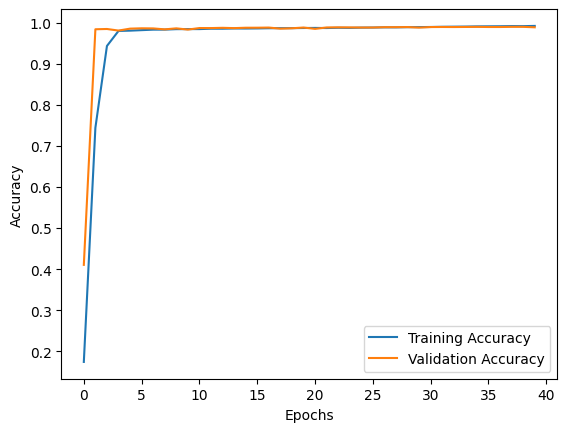

In [30]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

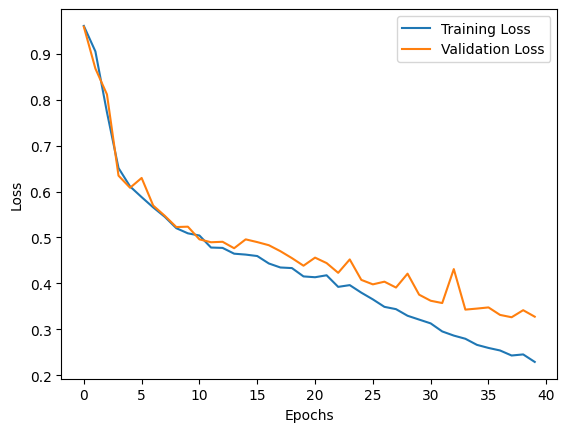

In [31]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
u_net_loss,u_net_accuracy,u_net_dice_coef=model.evaluate(X_test,y_test)
print(f'Loss is {u_net_loss}')
print(f'Accuracy is {u_net_accuracy}')
print(f'Dice_Coef is {u_net_dice_coef}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - accuracy: 0.9898 - dice_coef: 0.6524 - loss: 0.3478
Loss is 0.34171271324157715
Accuracy is 0.9898405075073242
Dice_Coef is 0.6607431769371033


In [33]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 670ms/step


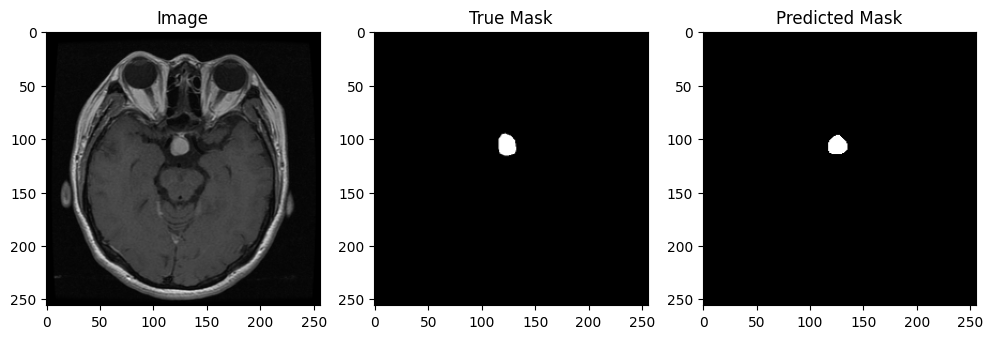

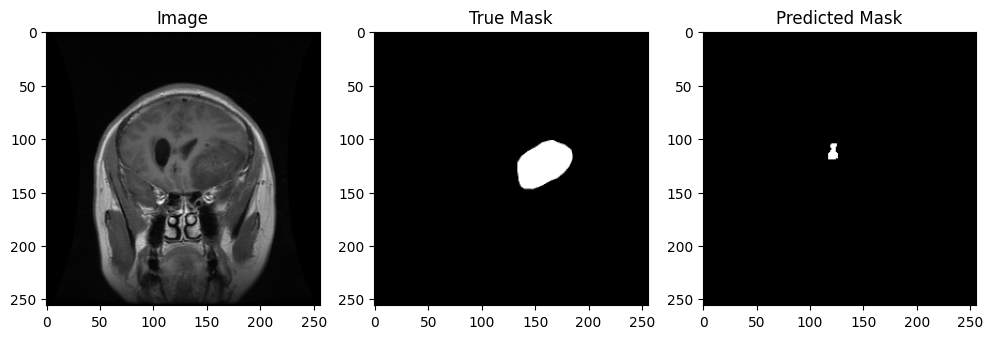

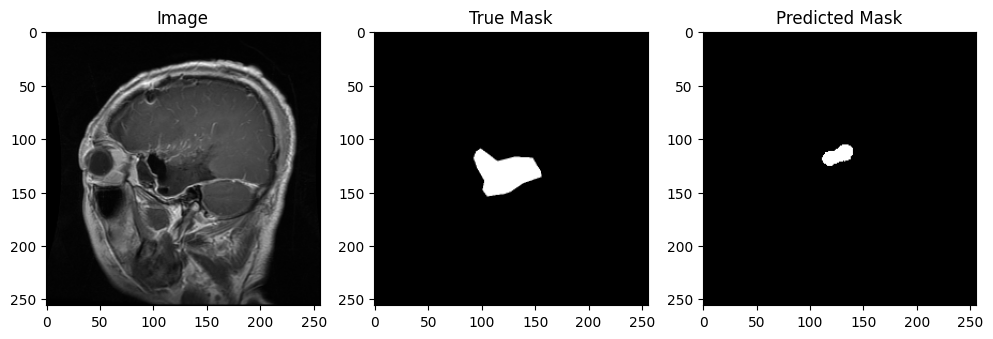

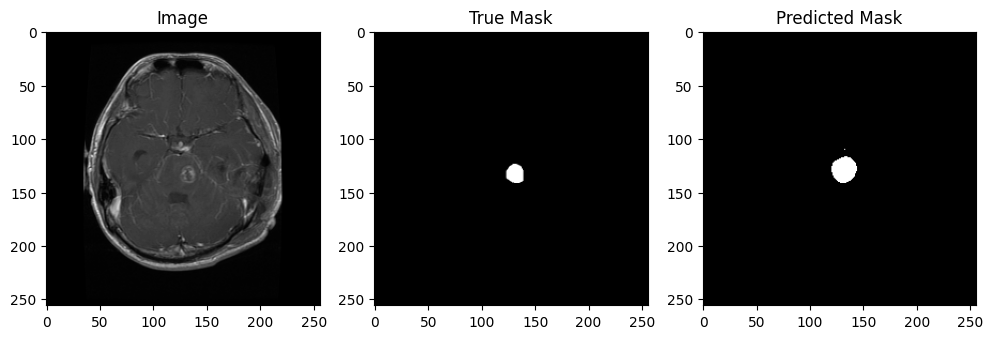

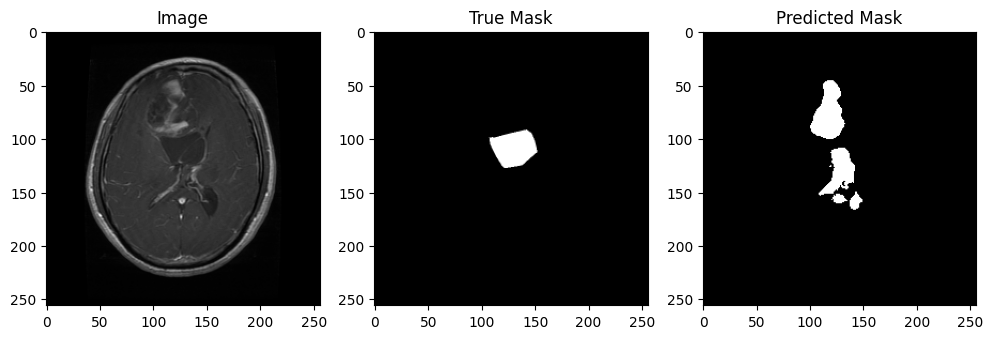

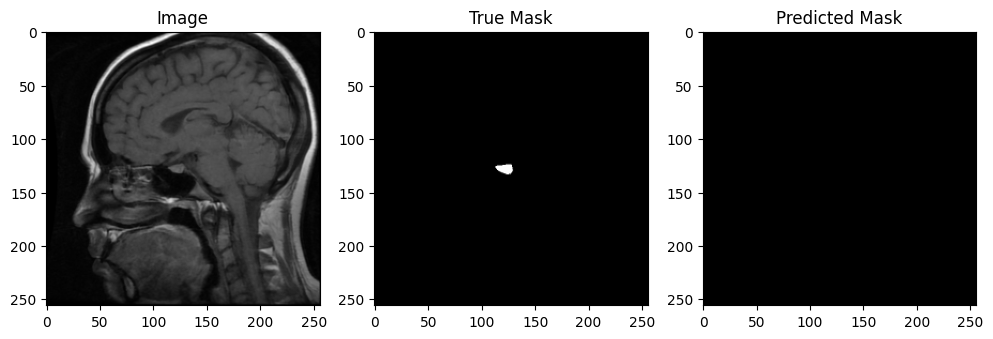

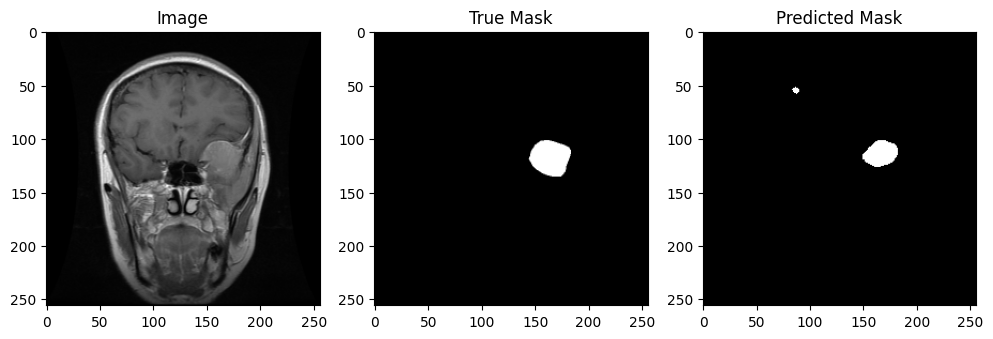

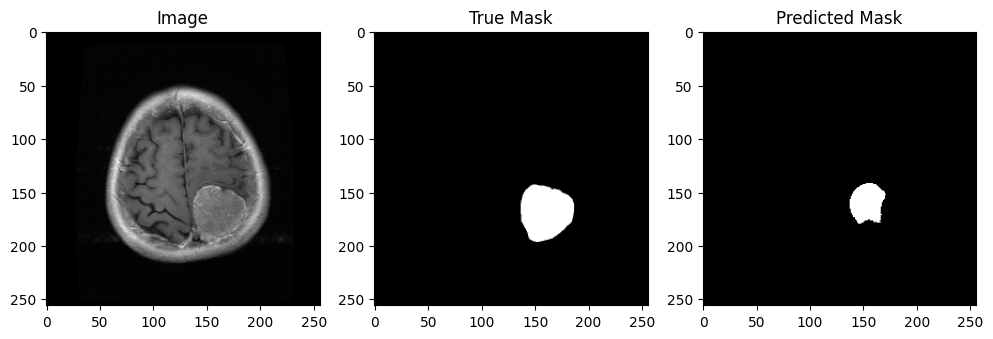

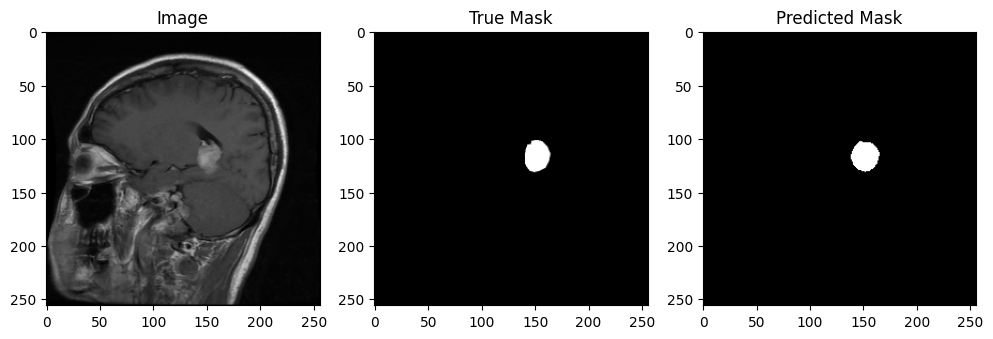

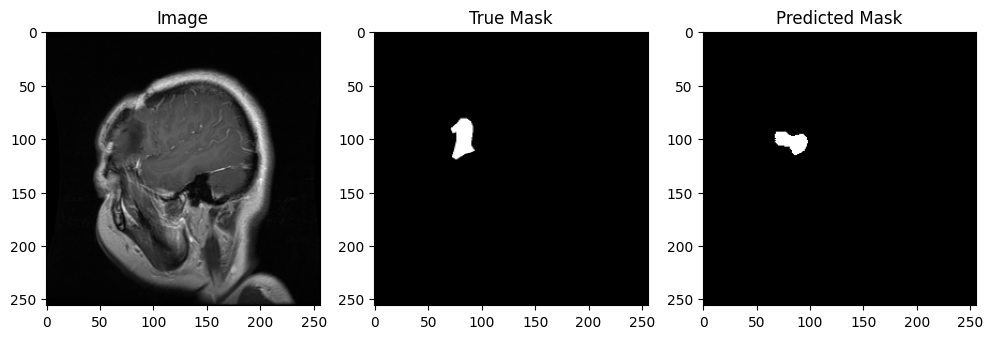

In [34]:
for i in range(10):
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    
    plt.show()